In [1]:
# pip installs

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn import TransformerDecoder, TransformerDecoderLayer
from torch.nn import Transformer

from sklearn.model_selection import train_test_split
import statistics
from tqdm import tqdm

from zipfile import ZipFile

from tokenizers import Tokenizer, models, pre_tokenizers, trainers
from transformers import AutoTokenizer, AutoModelForMaskedLM

import requests
import os
import json

from torch.utils.data import Dataset, DataLoader, random_split
import random

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Define seeds

In [3]:
# define seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Data preprocessing

### here we need to load the data and extract only data with vowels punctuations

In [4]:
# path to the jason file for the dataset
data_json_path = 'data/books.json'

# Root directory where the downloaded files will be saved
texts_path = 'data/texts'


# Create the directory if it does not exist
if not os.path.exists(texts_path):
    os.makedirs(texts_path)


# Load the json dataset
with open(data_json_path, 'r', encoding='utf-8') as f:
    jason_data = json.load(f)

# download the files and save them in a folder

#### remove\add the comment as needed

In [5]:
# # Loop through the json dataset and download the files
# for entry in tqdm(jason_data):
#     try:
#         # Download the Nikud Meteg file
#         if entry['fileName'] + '__nikud_meteg' in os.listdir(texts_path):
#             continue
#         nikud_meteg_url = entry['nikudMetegFileURL']
#         nikud_meteg_local_path = os.path.join(texts_path, entry['fileName'] + '__nikud_meteg.zip')
#         nikud_meteg_response = requests.get(nikud_meteg_url)
#         with open(nikud_meteg_local_path, 'wb') as f:
#             f.write(nikud_meteg_response.content)

#             # Unzip the Nikud Meteg file
#             with ZipFile(nikud_meteg_local_path, 'r') as zipObj:
#                 zipObj.extractall(os.path.join(texts_path, entry['fileName'] + '__nikud_meteg'))
#     except Exception as e:
#         print(f"Error reading file {entry['fileName']}: {e}")
#         continue


# # iterate through the texts folder and delete the zip folders
# for file in tqdm(os.listdir(texts_path)):
#     if file.endswith(".zip"):
#         os.remove(os.path.join(texts_path, file))

# Author files

### Create a dictionary whose keys are authors and values are a list containing all it's files

In [6]:
# Define a method to create the author files dictionary
def create_author_files_dict(author_files):
    """
    This function creates a dictionary of author files with a list of their corresponding texts.
    """
    author_files_dict = {}
    for file in author_files:
        author_files_dict[file] = []
        for text_file_name in os.listdir(os.path.join(texts_path, file)):
            if text_file_name.endswith('.txt'):
                author_files_dict[file].append(text_file_name)
    return author_files_dict

author_files = os.listdir(texts_path)
author_files_dict = create_author_files_dict(author_files)

# Functions to clean the data

In [7]:
# Nikud unicode range (https://en.wikipedia.org/wiki/Unicode_and_HTML_for_the_Hebrew_alphabet)


#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}

# Read a txt file from the author files dictionary
def read_txt_file(file_path):
    """
    This function reads a txt file and returns the text as a string.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    return text

def remove_nikud(string):
    """Removes the nikud from the given string."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    return nikud.sub("", string)

def get_nikud(word):
    """Returns the nikud from the given word."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    current_nikud = ''
    nikud_arr = []
    for i in range(len(word)):
        if i == 0:
            continue
        if nikud.match(word[i]):
            current_nikud += word[i]
        else:
            nikud_arr.append(current_nikud)
            current_nikud = ''
    nikud_arr.append(current_nikud)
    return nikud_arr

def add_nikud(word, nikud):
    """Adds the nikud to the given word."""
    new_word = ''
    for i in range(len(word)):
        new_word += word[i] + nikud[i]
    return new_word

def add_nikud_to_text(text, nikud):
    """Adds the nikud to the given text."""
    new_text = ''
    for word in text.split(' '):
        new_text += add_nikud(word, nikud) + ' '
    return new_text

def remove_first_char_if_nikud(word):
    """Removes the first char of the word if it is nikud."""
    nikud = re.compile(r'[\u0591-\u05C7]')
    if nikud.match(word[0]):
        return word[1:]
    return word

def get_words_indices_from_text(text):
    text_words = text.split()
    text_words_lengths = list(map(len, text_words))
    text_words_indices = [(sum(text_words_lengths[:i]), sum(text_words_lengths[:i+1])-1) for i in range(len(text_words_lengths))]
    return text_words_indices

### Test nikud functions

In [8]:
# test the functions for adding and removing nikud
text = read_txt_file(os.path.join(texts_path, 'afikeiyam1__nikud_meteg', 'afikeiyam1-002__nikud_meteg.txt'))
# take just the first 100 characters
text = text[:100]
# remove extra spaces
text = re.sub(' +', ' ', text)
# trim text
text = text.strip()
# text_no_nikud = remove_nikud(text)
# text_nikud = get_nikud(text)
# text_with_nikud = add_nikud_to_text(text_no_nikud, text_nikud)

sentence_words = text.split()
print(f'sentence_words: {sentence_words} len: {len(sentence_words)}')
# remove the nikud from the sentence
sentence_without_nikud = remove_nikud(text)
sentence_words_without_nikud = sentence_without_nikud.split()
# get the nikud from the sentence
nikud = list(map(get_nikud, sentence_words))
print(f'nikud: {nikud} len: {len(nikud)}')
for i in range(len(sentence_words)):
    # print(f'Original word: {sentence_words[i]}')
    # print(f'Nikud: {nikud[i]}')
    # print(f'Word with nikud: {add_nikud(sentence_words_without_nikud[i], nikud[i])}')
    print(f'Original word {"==" if sentence_words[i] == add_nikud(sentence_words_without_nikud[i], nikud[i]) else "!="} word with nikud')

# sentence_with_nikud = []
# for i, word in enumerate(sentence_words):
#     sentence_with_nikud.append(add_nikud_to_text(word, nikud[i]))
# print(' '.join(sentence_with_nikud))

# print("original text:\n", text)
# print("text with added nikud:\n", text_with_nikud)
# print("text without nikud:\n", text_no_nikud)
# print("nikud array:\n", text_nikud)
# print("original is equal to text with added nikud:", text == text_with_nikud)

sentence_words: ['פֶּתַח', 'דָּבָר', 'יִתְבָּרֵךְ', 'הַבּוֹרֵא', 'וְיִשְׁתַּבַּח', 'הַיּוֹצֵר', 'אֲשֶׁר', 'מֵעוּדַי', 'גָּבַר', 'עָלַי', 'חַסְדּוֹ'] len: 11
nikud: [['ֶּ', 'ַ', ''], ['ָּ', 'ָ', ''], ['ִ', 'ְ', 'ָּ', 'ֵ', 'ְ'], ['ַ', 'ּ', 'ֹ', 'ֵ', ''], ['ְ', 'ִ', 'ְׁ', 'ַּ', 'ַּ', ''], ['ַ', 'ּ', 'ֹ', 'ֵ', ''], ['ֲ', 'ֶׁ', ''], ['ֵ', '', 'ּ', 'ַ', ''], ['ָּ', 'ַ', ''], ['ָ', 'ַ', ''], ['ַ', 'ְ', 'ּ', 'ֹ']] len: 11
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud
Original word == word with nikud


## Create a unified csv of all sentences

In [9]:
import csv

#dictionary of nikud to name
nikud_dict = { 'ְ' : 'Sheva', 'ֱ' : 'Hataf Segol', 'ֲ' : 'Hataf Patah', 'ֳ' : 'Hataf Qamats', 'ִ' : 'Hiriq', 'ֵ' : 'Tseri', 'ֶ' : 'Segol', 'ַ' : 'Patah', 'ָ' : 'Qamats', 'ֹ' : 'Holam', 'ֻ' : 'Qubuts', 'ּ' : 'Dagesh', 'ֽ' : 'Siluk', '־' : 'Maqaf', 'ֿ' : 'Rafe', 'ׁ' : 'Shin Dot', 'ׂ' : 'Sin Dot', 'ׄ' : 'Upper Dot', 'ׅ' : 'Lower Dot', 'ׇ' : 'Point Meteg', 'װ' : 'Yiddish Double Vav', 'ױ' : 'Yiddish Vav Yod', 'ײ' : 'Yiddish Double Yod', '׳' : 'Geresh', '״' : 'Gershayim' }
# make inverse dictionary
nikud_dict_inv = {v: k for k, v in nikud_dict.items()}
# columns = ['text_with_nikud', 'text_without_nikud', 'nikud', 'author', 'file_name', 'sentence_num']
# with open('data/full_data_without_puncts.csv', 'w', encoding='utf-8') as f:
#     writer = csv.writer(f)
#     writer.writerow(columns)
#     for author in tqdm(author_files_dict):
#         for file in author_files_dict[author]:
#             text = read_txt_file(os.path.join(texts_path, author, file))
#             sentences = re.split(r'\n|\.', text)
#             for i, sentence in enumerate(sentences):
#                 sentence = re.sub('\'|\"|\(|\)', '', sentence)
#                 # Remove Dagesh, Shin Dot, Sin Dot using nikud_dict_inv
#                 sentence = re.sub(nikud_dict_inv['Dagesh'], '', sentence)
#                 sentence = re.sub(nikud_dict_inv['Shin Dot'], '', sentence)
#                 sentence = re.sub(nikud_dict_inv['Sin Dot'], '', sentence)
#                 # Keep only the nikud and hebrew letters and spaces
#                 sentence = re.sub(r'[^א-ת' + ''.join(nikud_dict.keys()) + '\s]', '', sentence)
#                 # remove multiple spaces
#                 sentence = re.sub(r'\s+', ' ', sentence)
#                 sentence = sentence.strip()
#                 if sentence == '':
#                     continue
#                 # split the sentence into words
#                 sentence_words = sentence.split()
#                 # remove the nikud from the sentence
#                 sentence_without_nikud = remove_nikud(sentence)
#                 # make sure first char is not in [\u0591-\u05C7]
#                 sentence_words = list(map(remove_first_char_if_nikud, sentence_words))
#                 sentence_words = [word for word in sentence_words if word != '']
#                 # get the nikud from the sentence
#                 nikud = list(map(get_nikud, sentence_words))
            
#                 flag = True
#                 no_nikud_words = sentence_without_nikud.split()
#                 for j in range(len(no_nikud_words)):
#                     if sentence_words[j] != add_nikud(no_nikud_words[j], nikud[j]):
#                         test_word = sentence_words[j]
#                         flag = False
#                         print('No match')
                            
#                 # add the sentence to the dataframe
#                 writer.writerow([sentence, sentence_without_nikud, nikud, author, file, i])

#### load the data from the csv for chuncks and save first chunck in json for short data

In [10]:
# # dataframe of the CSV with chunksize of 1000
# #data_df_chunks = pd.read_csv('data/full_data.csv', chunksize=1000)

# #read only first 100000 rows of the CSV, we will use this for now
# data_df = pd.read_csv('data/full_data_without_puncts.csv', nrows=200000, converters={'nikud': eval})
# print(data_df.head())

# # keep only rows s.t the length of the text (without spaces) is at most 100
# data_df = data_df[data_df['text_without_nikud'].str.replace(' ', '').str.len() <= 100]

# # save the dataframe to a json file
# data_df.to_json('data/full_data_without_puncts.json', orient='records', lines=True)

##### read the json short data

In [11]:
# read the json file
data_df = pd.read_json('data/full_data_without_puncts.json', orient='records', lines=True, nrows=55000)
print(data_df.shape)
# print(data_df.columns)

(55000, 6)


In [12]:
# DELETE this block, only for debugging make the data smaller (randomly select 5000 rows)
data_df = data_df.sample(n=5000, random_state=1)
print(data_df.shape)

(5000, 6)


In [13]:
for i in range(len(data_df)):
    original_text = data_df.iloc[i]['text_with_nikud']
    processed_text = data_df.iloc[i]['text_without_nikud'].split()
    nikud = data_df.iloc[i]['nikud']
    sentence = ''
    for j in range(len(processed_text)):
        sentence += add_nikud(processed_text[j], nikud[j]) + ' '
    # remove the last space
    sentence = sentence[:-1]
    if original_text.strip(' ') != sentence:
        print('Original text:\n', original_text.strip(' '))
        print('Original text length: ', len(original_text.strip(' ')))
        print('Processed text:\n', sentence)
        print('Processed text length: ', len(sentence))
        # check character by character
        for k in range(len(original_text.strip(' '))):
            if original_text.strip(' ')[k] != sentence[k]:
                print('Character: ', original_text.strip(' ')[k])
                print('Character: ', sentence[k])
                print('Index: ', k)
                break
        print('-----------------------------------')
        break

#### Define dictionary label_to_id and id_to_label


In [14]:
label_to_id = {}
id_to_label = {}
for label_list in tqdm(data_df['nikud']):
    # flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_to_id:
            label_to_id[label] = len(label_to_id)
            id_to_label[len(id_to_label)] = label

print(label_to_id)



100%|██████████| 5000/5000 [00:00<00:00, 106687.83it/s]

{'ְ': 0, 'ִ': 1, 'ֵ': 2, '<no_nikud>': 3, 'ֶ': 4, 'ֹ': 5, 'ֽ': 6, 'ָ': 7, 'ֲ': 8, 'ַ': 9, 'ֻ': 10, 'ֱ': 11, 'ׇ': 12, 'ֳ': 13, 'ַָ': 14, 'ִַ': 15}


#### count labels for label_weights

100%|██████████| 5000/5000 [00:00<00:00, 82921.86it/s]


{'ְ': 25929, 'ִ': 16984, 'ֵ': 10315, '<no_nikud>': 91941, 'ֶ': 8265, 'ֹ': 9664, 'ֽ': 5095, 'ָ': 23296, 'ֲ': 2770, 'ַ': 18470, 'ֻ': 1059, 'ֱ': 353, 'ׇ': 490, 'ֳ': 49, 'ַָ': 1, 'ִַ': 1}
[('<no_nikud>', 91941), ('ְ', 25929), ('ָ', 23296), ('ַ', 18470), ('ִ', 16984), ('ֵ', 10315), ('ֹ', 9664), ('ֶ', 8265), ('ֽ', 5095), ('ֲ', 2770), ('ֻ', 1059), ('ׇ', 490), ('ֱ', 353), ('ֳ', 49), ('ַָ', 1), ('ִַ', 1)]


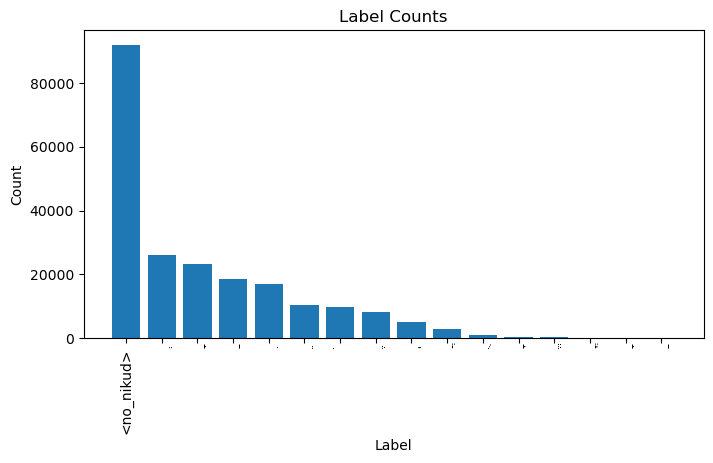

{'ְ': 0.06523157208088715, 'ִ': 0.06523157208088715, 'ֵ': 0.06523157208088715, '<no_nikud>': 0.02152641878669276, 'ֶ': 0.06523157208088715, 'ֹ': 0.06523157208088715, 'ֽ': 0.06523157208088715, 'ָ': 0.06523157208088715, 'ֲ': 0.06523157208088715, 'ַ': 0.06523157208088715, 'ֻ': 0.06523157208088715, 'ֱ': 0.06523157208088715, 'ׇ': 0.06523157208088715, 'ֳ': 0.06523157208088715, 'ַָ': 0.06523157208088715, 'ִַ': 0.06523157208088715}
label name = Sheva
label name = Hiriq
label name = Tseri
f label name = <no_nikud>
label name = Segol
label name = Holam
label name = Siluk
label name = Qamats
label name = Hataf Patah
label name = Patah
label name = Qubuts
label name = Hataf Segol
label name = Point Meteg
label name = Hataf Qamats
label name =  Qamats Patah
label name =  Hiriq Patah


In [15]:
# Count the number of each label
label_count = {}
for label_list in tqdm(data_df['nikud']):
    # Flatten the list
    label_list = [item for sublist in label_list for item in sublist]
    for label in label_list:
        if len(label) == 0:
            label = "<no_nikud>"
        if label not in label_count:
            label_count[label] = 0
        label_count[label] += 1

print(label_count)

# Plot counts of each label (sorted)
sorted_labels = sorted(label_count.items(), key=lambda x: x[1], reverse=True)
print(sorted_labels)
plt.figure(figsize=(8, 4))
plt.xticks(rotation=90)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Counts')
plt.bar([x[0] for x in sorted_labels], [x[1] for x in sorted_labels])
plt.show()

# Define the label weights
label_weights = {}
for label in label_count:
    if label == "<no_nikud>":
        label_weights[label] = 0.33
    else:
        label_weights[label] = 1

# Normalize the weights
sum_weights = sum(label_weights.values())
for label in label_weights:
    label_weights[label] /= sum_weights

def set_no_nikud_weight(weight=0.33):
    label_weights = {}
    for label in label_count:
        if label == "<no_nikud>":
            label_weights[label] = weight
        else:
            label_weights[label] = 1
    sum_weights = sum(label_weights.values())
    for label in label_weights:
        label_weights[label] /= sum_weights
    return label_weights
        

print(label_weights)

for label in label_weights.keys():
    if label == "<no_nikud>":
        print(f'f label name = {label}')
    elif len(label) == 1:
        print(f'label name = {nikud_dict[label]}')
    else:
        label_name = ""
        for char in label:
            label_name += " " + nikud_dict[char]
        print(f'label name = {label_name}')
    

### EDA - DataAnalysis on short_df

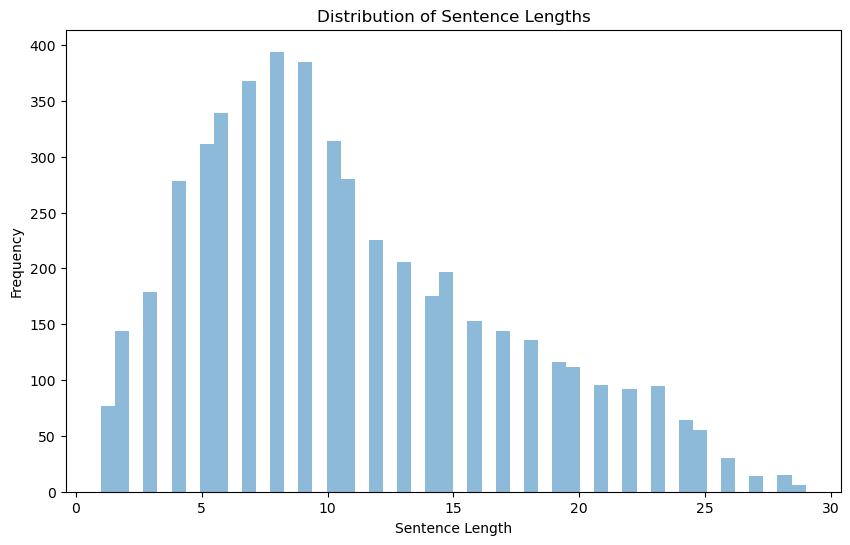

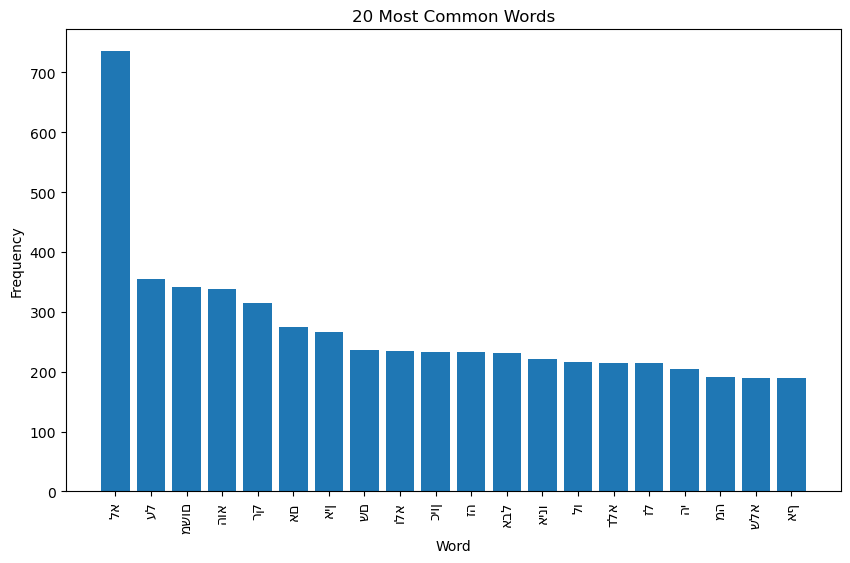

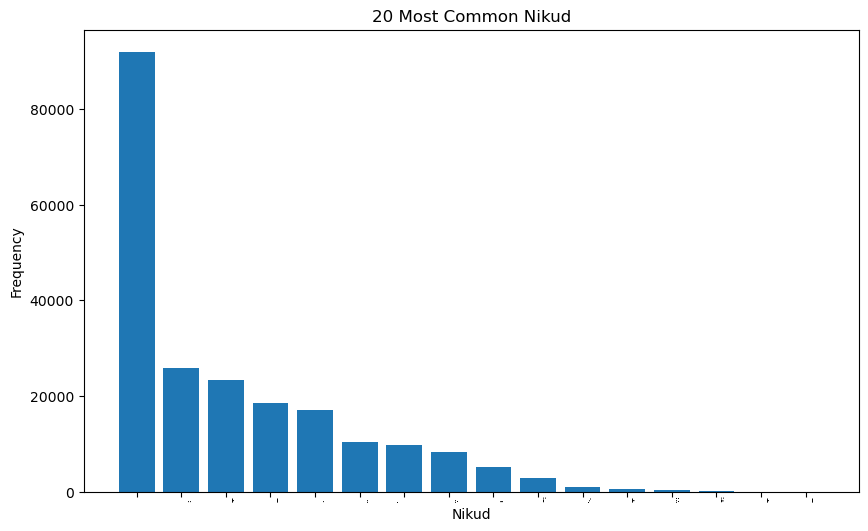

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain

class DataAnalysis:
    def __init__(self, data_df):
        self.data_df = data_df.copy()
        
    def author_distribution(self):
        # Distribution of authors
        author_distribution = self.data_df['author'].value_counts()

        # Bar plot of the distribution of the top 20 authors
        plt.figure(figsize=(10, 6))
        author_distribution[:20].plot(kind='bar')
        plt.xlabel('Author')
        plt.ylabel('Frequency')
        plt.title('Top 20 Authors')
        plt.xticks(rotation=90)
        plt.show()
        
    def file_distribution(self):
        # Distribution of files
        file_distribution = self.data_df['file_name'].value_counts()

        # Bar plot of the distribution of the top 20 files
        plt.figure(figsize=(10, 6))
        file_distribution[:20].plot(kind='bar')
        plt.xlabel('File')
        plt.ylabel('Frequency')
        plt.title('Top 20 Files')
        plt.xticks(rotation=90)
        plt.show()
        
    def sentence_length_distribution(self):
        # Create a new column for sentence length
        self.data_df['sentence_length'] = self.data_df['text_without_nikud'].str.split().str.len()

        # Get the distribution of sentence lengths
        sentence_length_distribution = self.data_df['sentence_length'].value_counts().sort_index()

        # Histogram of the distribution of sentence lengths
        plt.figure(figsize=(10, 6))
        plt.hist(self.data_df['sentence_length'], bins=50, alpha=0.5)
        plt.xlabel('Sentence Length')
        plt.ylabel('Frequency')
        plt.title('Distribution of Sentence Lengths')
        plt.show()
        
    def common_words(self):
        # Tokenize the sentences
        tokenized_sentences = self.data_df['text_without_nikud'].str.split()

        # Flatten the list of tokens and count the frequency of each token
        word_counts = Counter(chain.from_iterable(tokenized_sentences))

        # Get the 20 most common words
        common_words = word_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common words
        plt.figure(figsize=(10, 6))
        words, counts = zip(*common_words)
        plt.bar(words, counts)
        plt.xlabel('Word')
        plt.ylabel('Frequency')
        plt.title('20 Most Common Words')
        plt.xticks(rotation=90)
        plt.show()
        
    def common_nikud(self):
        # Flatten the list of Nikud and count the frequency of each Nikud
        nikud_counts = Counter(chain.from_iterable(chain.from_iterable(self.data_df['nikud'])))

        # Get the 20 most common Nikud
        common_nikud = nikud_counts.most_common(20)

        # Bar plot of the frequency of the 20 most common Nikud
        plt.figure(figsize=(10, 6))
        nikud, counts = zip(*common_nikud)
        plt.bar(nikud, counts)
        plt.xlabel('Nikud')
        plt.ylabel('Frequency')
        plt.title('20 Most Common Nikud')
        plt.xticks(rotation=90)
        plt.show()

# instantiate the class and call the methods
data_analysis = DataAnalysis(data_df)
#data_analysis.author_distribution()
#data_analysis.file_distribution()
data_analysis.sentence_length_distribution()
data_analysis.common_words()
data_analysis.common_nikud()


#### download tokenizer and model
(alephbert-base, with vocab of words with len <= 1)

In [17]:
model_path = 'C:\\Users\\baruc\\PycharmProjects\\pythonProject\\Punctuation_Restoration\\AlephBERT-main\\AlephBERT-main\\models\\alephbert-base'
alephbert_tokenizer = AutoTokenizer.from_pretrained(model_path)
alephbert_model = AutoModelForMaskedLM.from_pretrained("onlplab/alephbert-base")

In [18]:
# test the tokenization and detokenization
test = "בדיקה של הדבר הזה"
tokenized = alephbert_tokenizer.tokenize(test)
encoded = alephbert_tokenizer.encode(test)
decoded = alephbert_tokenizer.decode(encoded)
print(test)
print("tokenized: ", tokenized)
print("encoded: ", encoded)
print("decoded: ", decoded)

בדיקה של הדבר הזה
tokenized:  ['ב', '##ד', '##י', '##ק', '##ה', 'ש', '##ל', 'ה', '##ד', '##ב', '##ר', 'ה', '##ז', '##ה']
encoded:  [2, 177, 1039, 1008, 1013, 1016, 201, 1009, 180, 1039, 1037, 1014, 180, 1075, 1016, 3]
decoded:  [CLS] בדיקה של הדבר הזה [SEP]


In [19]:
data_df.head()

,text_with_nikud,text_without_nikud,nikud,author,file_name,sentence_num
47910,וְהִנֵה לְפִי משל חֶדֶר ד בְאֹוֽרֶךְ דיל דעא ה...,והנה לפי משל חדר ד באורך דיל דעא הוי כמו חזקה ...,"[[ְ, ִ, ֵ, ], [ְ, ִ, ], [, , ], [ֶ, ֶ, ], [], ...",bayitneeman__nikud_meteg,bayitneeman-037__nikud_meteg.txt,21
47943,וְכֵן אִם קִיֽדֵש אִשָה הָיְתָה מְקֻוֽדֶשֶת וַ...,וכן אם קידש אשה היתה מקודשת ודאי דעא נאמן במקו...,"[[ְ, ֵ, ], [ִ, ], [ִ, ֽ, ֵ, ], [ִ, ָ, ], [ָ, ְ...",bayitneeman__nikud_meteg,bayitneeman-038__nikud_meteg.txt,35
30637,ומְשַנֵי אָמַר קְרָא בְקֶרֶב יִשְרָאֵל בִזְמַן...,ומשני אמר קרא בקרב ישראל בזמן ששלום בישראל,"[[, ְ, ַ, ֵ, ], [ָ, ַ, ], [ְ, ָ, ], [ְ, ֶ, ֶ, ...",avneinezeryorehdeah__nikud_meteg,avneinezeryorehdeah-329__nikud_meteg.txt,56
39912,ממ חַיָיֽב כָרֵת עַל בִיאָתוֹ לַמִקְדָש,ממ חייב כרת על ביאתו למקדש,"[[, ], [ַ, ָ, ֽ, ], [ָ, ֵ, ], [ַ, ], [ִ, , ָ, ...",avneinezeryorehdeah__nikud_meteg,avneinezeryorehdeah-495__nikud_meteg.txt,51
34608,מִכׇל הָלֵין טַעְמֵי נִרְאֶה בָרור שֶמֻוֽתָר ל...,מכל הלין טעמי נראה ברור שמותר למוחקו הק אברהם,"[[ִ, ׇ, ], [ָ, ֵ, , ], [ַ, ְ, ֵ, ], [ִ, ְ, ֶ, ...",avneinezeryorehdeah__nikud_meteg,avneinezeryorehdeah-399__nikud_meteg.txt,1


In [20]:
data_df.iloc[0]
text = data_df.iloc[0]['text_without_nikud']
nikud = data_df.iloc[0]['nikud']
for row in data_df.iterrows():
    text = row[1]['text_without_nikud']
    text_with_nikud = row[1]['text_with_nikud']
    nikud = row[1]['nikud']
    text_words = text.split()
    sentence = []
    for i in range(len(nikud)):
        sentence.append(add_nikud(text_words[i], nikud[i]))
    sentence = ' '.join(sentence)
    if sentence != text_with_nikud:
        print(sentence)
        print(text_with_nikud)
        print('------------------')

# create DataSet class

In [21]:
# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))

class PunctuationRestorationDataset(Dataset):
    def __init__(self, data_df, tokenizer, label_to_id, max_len):
        self.data = data_df
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.label_to_id = label_to_id 
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index): # TODO: need to make sure not to look at fraction of words
        text = self.data.iloc[index]['text_without_nikud']
        nikud = self.data.iloc[index]['nikud']  # list of lists of nikud

        # flatten nikud list
        nikud = [item for sublist in nikud for item in sublist]

        # replace empty strings with <no_nikud> token
        nikud = [label if label != "" else "<no_nikud>" for label in nikud]
        # replace labels with ids
        nikud = [self.label_to_id[label] for label in nikud]

        # check if nikud length is the same as text without spaces length
        if len(text.replace(" ", "")) != len(nikud):
            print("text without spaces length: ", len(text.replace(" ", "")))
            print("nikud length: ", len(nikud))
        
        # get word indices after tokenization
        word_indices = get_words_indices_from_text(text)
        # pad word_indices to be the same length as input_ids
        word_indices = word_indices + [(-1, -1)] * (self.max_len - len(word_indices))
        # convert word_indices to tensor
        word_indices = torch.tensor(word_indices, dtype=torch.long)
        # print("word_indices shape: ", word_indices.shape)
        # print("word_indices: ", word_indices)
       

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        # pad nikud to be the same length as input_ids
        nikud = nikud + [len(label_to_id)] * (encoding['input_ids'].shape[1] - len(nikud))
        # convert to tensor
        nikud = torch.tensor(nikud, dtype=torch.long)
        
        return {
            'text': text,
            'nikud': nikud,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'word_indices': word_indices
        }


# create pytorch dataset class for punctuation restoration (returns input(text) and target(nikud))
dataset = PunctuationRestorationDataset(data_df, alephbert_tokenizer, label_to_id, 100)
print("dataset length: ", len(dataset))

# iterate over dataset
# for i in range(len(dataset)):
#     sample = dataset[i]
#     Original = data_df.iloc[i]['text_with_nikud']
#     text_without_nikud = sample['text']
#     nikud = sample['nikud']
#     input_ids = sample['input_ids']
#     attention_mask = sample['attention_mask']
#     word_indices = sample['word_indices']
    
#     # convert nikud_id to nikud_label
#     nikud_after_id_to_label = [id_to_label[id] if id < len(id_to_label) else "<no_nikud>" for id in nikud.tolist()]
#     # add nikud to text without nikud
#     text_words = text_without_nikud.split()
#     text_words_with_nikud = []
#     for word_index, word in enumerate(text_words):
#         text_words_with_nikud.append(add_nikud(word, nikud_after_id_to_label[word_indices[word_index][0]:word_indices[word_index][1]+1]))
#     text_with_nikud = " ".join(text_words_with_nikud)
#     text_with_nikud = text_with_nikud.replace("<no_nikud>", "")
#     if text_with_nikud != Original:
#         print("text_with_nikud: ", text_with_nikud)
#         print("Original: ", Original)


dataset length:  5000


In [22]:
# iterate over dataset
for i in range(len(dataset)):
    # get sample
    sample = dataset[i]
    # print sample
    #print(sample)
    text = sample['text']
    nikud = sample['nikud']
    input_ids = sample['input_ids']
    attention_mask = sample['attention_mask']
    # check if padding corresponds between input_ids and attention_mask and nikud
    nikud_pad_label = len(label_to_id)
    input_id_pad_label = alephbert_tokenizer.pad_token_id
    attention_mask_pad_label = 0
    # print("nikud pad label: ", nikud_pad_label)
    # print("input_id pad label: ", input_id_pad_label)
    # print("attention_mask pad label: ", attention_mask_pad_label)
    # get index of first padding token
    # nikud_pad_index = np.where(nikud == nikud_pad_label)[0][0]
    # input_id_pad_index = np.where(input_ids == input_id_pad_label)[0][0]
    # attention_mask_pad_index = np.where(attention_mask == attention_mask_pad_label)[0][0]
    # print("nikud pad index: ", nikud_pad_index)
    # print("input_id pad index: ", input_id_pad_index)
    # print("attention_mask pad index: ", attention_mask_pad_index)
    # if nikud_pad_index != input_id_pad_index or nikud_pad_index != attention_mask_pad_index:
    #     print("ERROR: padding indices do not match in sample {}".format(i))
    #     print("nikud pad index: {}, input_id pad index: {}, attention_mask pad index: {}".format(nikud_pad_index, input_id_pad_index, attention_mask_pad_index))
    #     print("text: ", text)
    #     print("nikud: ", nikud)
    #     print("input_ids: ", input_ids)
    #     print("attention_mask: ", attention_mask)
        
    

#### split to train,val and test datasets and dataloaders

In [23]:
# split dataset to train, val and test
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 32

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)



# performe EDAs on the data

In [24]:
# EDA on train, val and test dataset
print("train dataset size: ", len(train_dataset))
print("val dataset size: ", len(val_dataset))
print("test dataset size: ", len(test_dataset))

# train dataset
print("train dataset")
print(train_dataset[2])

train dataset size:  3600
val dataset size:  900
test dataset size:  500
train dataset
{'text': 'והה בהקדש המקדיש', 'nikud': tensor([ 3,  3,  3,  0,  4,  0,  2,  3,  9,  9,  0,  1,  3,  3, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 16, 16, 16, 16]), 'input_ids': tensor([ 181, 1016, 1016,  177, 1016, 1013, 1039, 1007,  180, 1005, 1013, 1039,
        1008, 1007,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0

# Define the two models (one with look-ahead, one without)

### train the two models

### Evaluate the models

## Full-Sentence Model

In [25]:
# define a charachter level transformer model with the following architecture:
# 1. Embedding layer
# 2. Transformer layer
# 3. Fully connected layer

embedding_dim = 512

class FullSentenceModel(nn.Module):
    """ Transformer model for Nikud restoration. """
    def __init__(self, vocab_size, embedding_dim=512, nhead=8, num_layers=6, output_dim=len(label_to_id), dropout=0.1):
        super(FullSentenceModel, self).__init__()
        
        # Non-pretrained embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
        self.transformer = nn.Transformer(d_model=embedding_dim, nhead=nhead, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dropout=dropout, activation='relu')
        
        # # Fully connected layer with ReLU activation function
        # self.fc = nn.Sequential(
        #     nn.Linear(embedding_dim, embedding_dim),
        #     nn.ReLU(),
        #     nn.Linear(embedding_dim, output_dim)
        # )

        self.fc = nn.Linear(embedding_dim, output_dim)
        

    def forward(self, sentence):
        # Pass input through embedding layer
        characters_embeddings = self.embedding(sentence)
        
        # Pass through transformer
        characters_after_transformer_layers = self.transformer(characters_embeddings, characters_embeddings)
        
        # Pass through fully connected layer
        predictions = self.fc(characters_after_transformer_layers)
        
        return predictions
    


In [26]:
# import math 
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :]
#         return self.dropout(x)

# # Modify your model's __init__ and forward methods:

# class FullSentenceModel(nn.Module):
#     """ Transformer model for Nikud restoration. """
#     def __init__(self, vocab_size, embedding_dim=512, nhead=8, num_layers=6, output_dim=len(label_to_id), dropout=0.1):
#         super(FullSentenceModel, self).__init__()
        
#         # Non-pretrained embedding layer
#         self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=0)
        
#         # Positional Encoding
#         self.pos_encoder = PositionalEncoding(embedding_dim, dropout)

#         self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dropout=dropout), num_layers=num_layers)
#         self.fc = nn.Linear(embedding_dim, output_dim)

#     def forward(self, sentence):
#         # Pass input through embedding layer
#         characters_embeddings = self.embedding(sentence)
        
#         # Add positional encodings
#         characters_embeddings = self.pos_encoder(characters_embeddings)

#         # Pass through transformer
#         characters_after_transformer_layers = self.transformer(characters_embeddings)
        
#         # Pass through fully connected layer
#         predictions = self.fc(characters_after_transformer_layers)
        
#         return predictions


Starting weight: 1


100%|██████████| 29/29 [00:01<00:00, 15.49it/s]


Epoch: 1, Train Loss: 1.8479, Val Loss: 1.5208


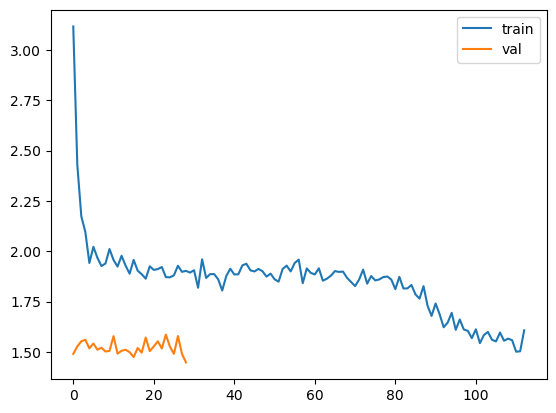

100%|██████████| 29/29 [00:01<00:00, 15.40it/s]


Epoch: 2, Train Loss: 1.4944, Val Loss: 1.4741


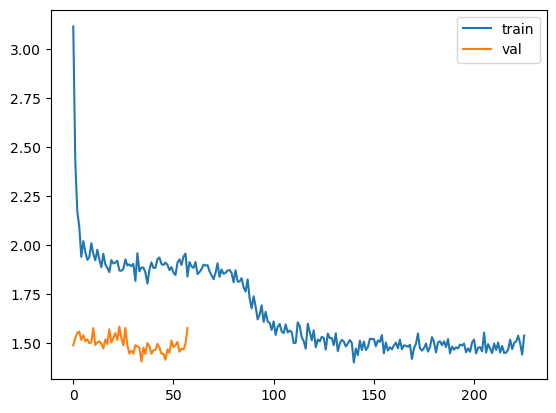

Finished weight: 1
-----------------------------------


In [27]:
from torch.optim.lr_scheduler import StepLR

vocab_size = len(alephbert_tokenizer.vocab)

# criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id)).to(device)
weights = torch.tensor(list(label_weights.values())).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)

train_loss_history = []
val_loss_history = []


# define the training loop
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['nikud'].to(device)
        predictions = model.forward(input_ids)#, labels)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        loss = criterion(predictions, labels)
        train_loss_history.append(loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# define the evaluation loop
def evaluate(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch['input_ids'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids)
            predictions = predictions.view(-1, predictions.shape[-1])
            labels = labels.view(-1)
            loss = criterion(predictions, labels)
            val_loss_history.append(loss.item())
            epoch_loss += loss.item()
    return epoch_loss / len(dataloader)

# define the training and evaluation loop
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        train_loss = train(model, train_dataloader, optimizer, criterion)
        scheduler.step()
        val_loss = evaluate(model, val_dataloader, criterion)
        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        # plot train and val loss history
        plt.plot(train_loss_history, label='train')
        plt.plot(val_loss_history, label='val')
        plt.legend()
        plt.show()


def hyperparameter_grid_search():
    # train the model
    nhead = [2, 4, 8]
    nlayers = [2, 4, 6]
    lr = [0.0001, 0.00001]
    for n in nhead:
        for l in nlayers:
            for r in lr:
                model = FullSentenceModel(vocab_size, nhead=n, num_layers=l).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=r)
                print(f'nhead: {n}, nlayers: {l}, lr: {r}')
                train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

# Imprortant reminder: Optimizer should be defined for each model separately
# model = FullSentenceModel(vocab_size, nhead=8, num_layers=6, embedding_dim=512).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# # Define AdamW optimizer
# # optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

# print number of trainable parameters
# print(f'Number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

label_weights_list = [1]#, 0.5, 0.33, 0.25]
for weight in label_weights_list:
    train_loss_history = []
    print(f'Starting weight: {weight}')
    model = FullSentenceModel(vocab_size, nhead=8, num_layers=6, embedding_dim=512).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    # Define AdamW optimizer
    # optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    label_weights = set_no_nikud_weight(weight)
    weights = torch.tensor(list(label_weights.values())).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id), weight=weights).to(device)
    train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs=2)
    print(f'Finished weight: {weight}')
    print('-----------------------------------')




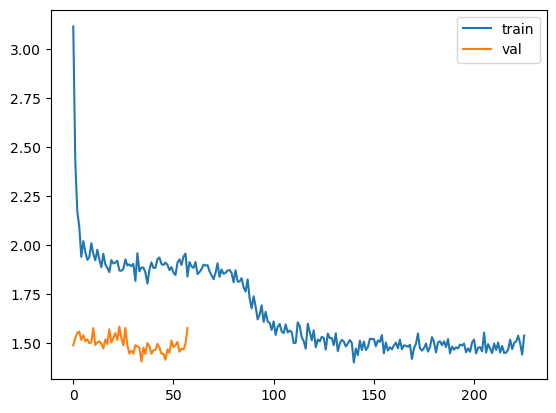

In [28]:
# plot train and val loss
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.legend()
plt.show()




In [29]:


for batch in test_loader:
    # predict on the first batch of the test set
    model.eval()
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        labels = batch['nikud'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        print("number of zeros in input_ids: ", torch.sum(input_ids == 0))
        print("number of 0 in attention_mask: ", torch.sum(attention_mask == 0))
        print("number of paddings in labels: ", torch.sum(labels == len(id_to_label)))

        # convert the input_ids to tokens
        tokens = alephbert_tokenizer.convert_ids_to_tokens(input_ids[0])
        # enumerate the tokens and their ids and save them in a dictionary
        token_ids = {i: token for i, token in enumerate(zip(input_ids[0].tolist(), tokens))}
        # save token_ids in a dataframe
        token_ids_df = pd.DataFrame.from_dict(token_ids, orient='index', columns=['id', 'token'])
        # add the labels to the dataframe
        token_ids_df['label'] = labels[0].tolist()
        predictions = model.forward(input_ids)
        predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)
        loss = criterion(predictions, labels)
        print("input_ids: ", input_ids)
        print("labels: ", labels)
        print("attention_mask: ", attention_mask)
        print(f'Predictions shape: {predictions.shape}')
        print("predictions: ", predictions)
        print(f'Loss: {loss.item():.4f}')
        # cut the padding tokens
        predictions = predictions[attention_mask.view(-1) == 1]
        labels = labels[attention_mask.view(-1) == 1]
        print(f'Predictions shape: {predictions.shape}')
        print(f'Labels shape: {labels.shape}')
        # get top 2 predictions
        predictions = torch.topk(predictions, k=2, dim=1).indices
        
        first_prediction = predictions[:, 0]
        second_prediction = predictions[:, 1]

        # Check for each element in first_prediction != 0, if so, check if it equals to the label
        correct_sum = 0
        overall_sum = 0
        for i in range(len(first_prediction)):
            if first_prediction[i] != 0:
                overall_sum += 1
                if first_prediction[i] == labels[i]:
                    correct_sum += 1
        accuracy = correct_sum / overall_sum
        print(f'Accuracy of actual nikud: {accuracy:.4f}')
        
        overall_sum = torch.sum(first_prediction == labels)#  + torch.sum(second_prediction == labels)
        

        # accuracy
        accuracy = overall_sum / len(labels)
        print(f'Accuracy: {accuracy.item():.4f}')

        # predictions = torch.argmax(predictions, dim=1)
        
        # check if the first or second prediction is correct 
        print("Predictions\tLabels\t\tFirst\t\tSecond")
        for i in range(50):
            print(f'{predictions[i].tolist()}\t\t{labels[i]}\t\t{predictions[i].tolist()[0] == labels[i]}\t\t{predictions[i].tolist()[1] == labels[i]}')

        print(f'Accuracy: {accuracy.item():.4f}')
        break

# for batch in test_loader:
#     # check if input_ids without padding matches the labels without padding
#     input_ids = batch['input_ids']
#     labels = batch['nikud']
#     # convert the input_ids to tokens
#     tokens = alephbert_tokenizer.convert_ids_to_tokens(input_ids[0])
#     # cut the padding tokens
#     input_ids = input_ids[0][input_ids[0] != 0]
#     labels = labels[0][labels[0] != len(id_to_label)]
#     if input_ids.shape != labels.shape:
#         print(f"input_ids shape: {input_ids.shape} vs labels shape: {labels.shape}")
#         print("input_ids: ", input_ids)
#         print("tokens: ", alephbert_tokenizer.convert_ids_to_tokens(input_ids))
#         print("labels: ", labels)
        


number of zeros in input_ids:  tensor(1821, device='cuda:0')
number of 0 in attention_mask:  tensor(1821, device='cuda:0')
number of paddings in labels:  tensor(1821, device='cuda:0')
input_ids:  tensor([[ 176, 1037, 1009,  ...,    0,    0,    0],
        [ 187, 1008, 1010,  ...,    0,    0,    0],
        [ 179, 1008, 1009,  ...,    0,    0,    0],
        ...,
        [ 181, 1033, 1066,  ...,    0,    0,    0],
        [ 181, 1039, 1047,  ...,    0,    0,    0],
        [ 190, 1007, 1033,  ...,    0,    0,    0]], device='cuda:0')
labels:  tensor([ 8,  7,  3,  ..., 16, 16, 16], device='cuda:0')
attention_mask:  tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')
Predictions shape: torch.Size([3200, 16])
predictions:  tensor([[-1.1536,  2.2073,  1.0463,  ..., -2.5562, -3.6494, -3.5941],
        [ 3.0080, 

#### Reading-Direction Model

In [33]:
# just a skeleton, need to be fixed
device = "cuda"

class ReadingDirectionModel(nn.Module):
    def __init__(self, char_vocab_size, char_embedding_dim, word_hidden_dim, char_hidden_dim, num_labels, word_lstm_layers=1, char_lstm_layers=4):
        super(ReadingDirectionModel, self).__init__()
        
        # Character Embedding Layer
        self.char_embedding = nn.Embedding(char_vocab_size, char_embedding_dim)
        
        # Word-Level BiLSTM
        self.word_bilstm = nn.LSTM(char_embedding_dim, word_hidden_dim, num_layers=word_lstm_layers, bidirectional=True, batch_first=True)
        
        # Character-Level LSTM
        self.char_lstm = nn.LSTM(char_embedding_dim + 2 * word_hidden_dim, char_hidden_dim, num_layers=char_lstm_layers, batch_first=True)
        
        # Fully Connected Layer
        self.fc = nn.Linear(char_hidden_dim, num_labels)
        
        # Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_sequence, word_boundaries):
        # Apply Character Embedding
        char_embedded = self.char_embedding(char_sequence)
        
        # Process each word using the Word-Level BiLSTM
        word_embeddings = []
        # word_boundries = [(0, 3), (4, 7), (8, 12)]
        for i, boundaries in enumerate(word_boundaries):
            print(boundaries)
            if boundaries[0] == -1:
                break
            word_seq = char_embedded[i, boundaries[0]:boundaries[1]+1, :]
            word_seq = word_seq.unsqueeze(0)
            # Take only the two last outputs from both sides of the BiLSTM
            last_word_embedding = self.word_bilstm(word_seq)[0][:, -1, :]
            first_word_embedding = self.word_bilstm(word_seq)[0][:, 0, :]
            word_embedding = torch.cat((first_word_embedding, last_word_embedding), dim=1)
            word_embeddings.append(word_embedding)
        
        char_word_embeddings = []
        for i, boundaries in enumerate(word_boundaries):
            if boundaries[0] == -1:
                break
            start_index = boundaries[0]
            end_index = boundaries[1]
            word_embedding = word_embeddings[i]
            for j in range(start_index, end_index+1):
                curr_char_embedding = char_embedded[:, j, :]
                char_word_embedding = torch.cat((curr_char_embedding, word_embedding), dim=1)
                char_word_embeddings.append(char_word_embedding)

        # Concatenate character embeddings with word embeddings
        # char_word_embeddings = torch.stack(char_word_embeddings)
        # char_word_embedded = torch.cat((char_embedded, char_word_embeddings), dim=2)
        # convert char_word_embeddings to tensor
        char_word_embedded = torch.stack(char_word_embeddings)

        # Apply Character-Level LSTM
        char_lstm_output, _ = self.char_lstm(char_word_embedded)
        
        # Apply Dropout
        char_lstm_output = self.dropout(char_lstm_output)
        
        # Apply Fully Connected Layer
        predictions = self.fc(char_lstm_output)
        
        return predictions

# Hyperparameters (example)
char_vocab_size = 128
char_embedding_dim = 32
word_hidden_dim = 16
char_hidden_dim = 512
num_labels = len(label_to_id)

# Creating the model instance (example)
reading_direction_model = ReadingDirectionModel(char_vocab_size, char_embedding_dim, word_hidden_dim, char_hidden_dim, num_labels).to(device)

# define train method
def train_lstm(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    train_accuracy = 0
    for batch in train_loader: # each sample in the batch is a dictionary with keys: 'text', 'nikud', 'input_ids', 'attention_mask', 'word_indices'
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        word_indices = batch['word_indices'].to(device)
        labels = batch['nikud'].to(device)
        optimizer.zero_grad()
        predictions = model.forward(input_ids, word_indices)
        loss = criterion(predictions.view(-1, num_labels), labels.view(-1))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        train_accuracy += (predictions.argmax(2) == labels).sum().item()
    return total_loss / len(train_loader), train_accuracy / len(train_loader.dataset)

# define evaluate method
def evaluate_lstm(model, eval_loader, criterion, device):
    model.eval()
    total_loss = 0
    eval_accuracy = 0
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            word_indices = batch['word_indices'].to(device)
            labels = batch['nikud'].to(device)
            predictions = model.forward(input_ids, word_indices)
            loss = criterion(predictions.view(-1, num_labels), labels.view(-1))
            total_loss += loss.item()
            eval_accuracy += (predictions.argmax(2) == labels).sum().item()
    return total_loss / len(eval_loader), eval_accuracy / len(eval_loader.dataset)

# define criterion and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=len(label_to_id)).to(device)
optimizer = optim.Adam(reading_direction_model.parameters(), lr=0.001)
train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []
# train the model
for epoch in range(1):
    train_loss, train_accuracy = train_lstm(reading_direction_model, train_loader, optimizer, criterion, device)
    eval_loss, eval_accuracy = evaluate_lstm(reading_direction_model, eval_loader, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)
    print(f'Epoch: {epoch+1:02}')
    print(f'Train Loss: {train_loss:.3f} | Train Accuracy: {train_accuracy*100:.2f}%')
    print(f'Eval Loss: {eval_loss:.3f} | Eval Accuracy: {eval_accuracy*100:.2f}%')
    print('-'*10)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Define the dual model class, it will be composed of two models.
#### whenever there is a disagreement between the two models, the model will add nikud using the lookahead model

## Evaluation of the dual model